In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import time
import cv2 
import glob
import json
import PIL
from PIL import Image, ImageDraw
import os
import numpy as np
from resizeimage import resizeimage
from statistics import mean, median
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import curve_fit
from skimage.morphology import skeletonize
from functions import *

# Use mask RCNN to perform detections and output results in (.npz) file for each image

In [ ]:
#load and define the model
model_path = '../mask rcnn model/trained model/60 epoch'
#model = get_model_instance_segmentation(2)
model = torch.load(model_path)
device = torch.device('cuda:0')
model.to(device)
model.eval()
model.roi_heads.score_thresh = 0.3  # or 0.1 
#_______________________________

#load the test images and use the model for prediction
image_root = 'examples/unwrapped images'
save_path = 'examples/detections'

test = list(sorted(os.listdir(image_root)))
transform = torchvision.transforms.ToTensor()

for im in test:
    img_path = os.path.join(image_root, im) 
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)
    img_tensor = img_tensor.to(device)
    predictions = model([img_tensor])
    for item in predictions[0]:
        predictions[0][item] = predictions[0][item].cpu().detach().numpy().tolist()    
    np.savez_compressed(os.path.join(save_path,im+'.npz'), **predictions[0])

In [3]:
image_root = 'examples/unwrapped images'

# Calculations of dip angle and dip direction for the detected fractures 

In [4]:
def sine(x, y, amp, c):
    b = 2 *math.pi /w
    return y + amp * np.sin(b * (x + c))


def sine2(x, y, amp, c,d):
    b = d * 2 *math.pi /w 
    return y + amp * np.sin(b * (x + c))


For confidentiality purposes, starting depths of images are not the real values


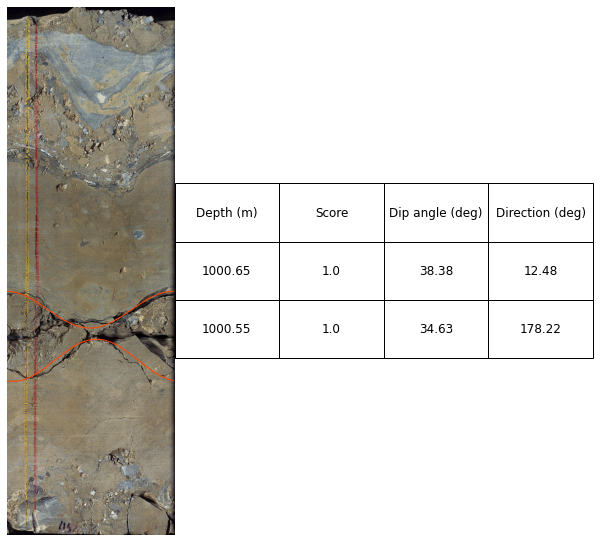

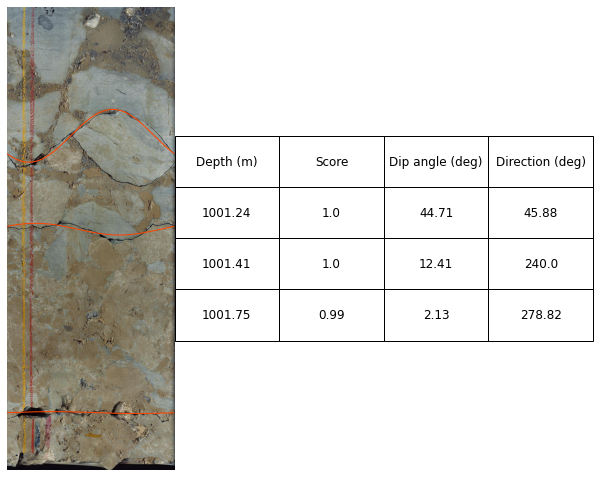

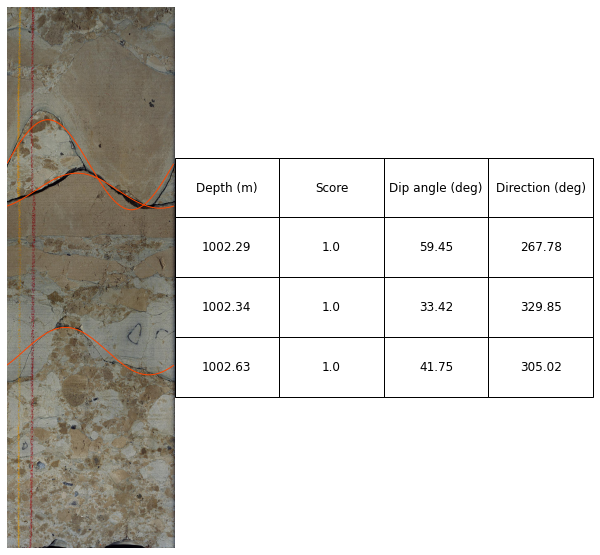

In [8]:
ann_root = 'examples/detections/*.npz'
anns = glob.glob(ann_root) #list(sorted(os.listdir(ann_root)))

#define varibales
scale = 2646  #the scale of images in pixels/meter
resize_ratio = 0.25 #resize to accelerate the calculations


for i,file in enumerate(anns):
    depth_f =[]
    scores_all = []
    dip_angle    =[]
    dip_direction=[]
    
    filename, file_extension = os.path.splitext(os.path.basename(file))
    ann = np.load(file) 
    masks = np.array(ann['masks'])
    scores = ann['scores']
    first_depth = get_first_depth(filename, '7220_6-1')
    
    image = read_img(os.path.join(image_root, filename))
    plt.figure(i, figsize =(3,10))
    plt.imshow(image)
    
    for mask,score in zip(masks,scores):
        mask = cv2.rotate(mask[0], rotateCode = cv2.ROTATE_90_CLOCKWISE)
        h0, w0= mask.shape
        mask = cv2.resize(mask,
                      (int(w0 * resize_ratio), int( h0* resize_ratio)), interpolation=cv2.INTER_AREA)
        mask_org = np.copy(mask)
        mask_th = (mask*255).astype('uint8')
        _,mask_th = cv2.threshold(mask_th,0,255,cv2.THRESH_BINARY)
        mask = skeletonize(mask_th, method='lee')
        h,w = mask.shape
        points = np.where(mask > 0)
        x, y = points[1],points[0]
        pixel_value = [mask_org[p] for p in zip(y,x)]
        #  first fit with range of b then remove points with err> median and fit with b =1
        params, _ = curve_fit(sine2, x, y,
                              p0=[0.5*h, 0.5*h , 0.5 * w,1],
                              sigma=(1/np.array(pixel_value)), absolute_sigma=False,
                              bounds = ([0,-0.5*h,-w,0.5],[h,0.5*h,w,2]), maxfev=500000)

        y_loc, amp, c,b = params
        new_y = sine2(x, y_loc, amp, c,b)
        # removing points with high error
        err_array = [abs(y1-y2) for (y1,y2) in zip(y, new_y)]
        x2 = []
        y2 = []
        for i ,(xi, yi) in enumerate (zip(x,y)):
            if err_array[i] < mean(err_array):
                x2.append(xi)
                y2.append(yi)
        # now fit again on x2,y2 and d=1
        pixel_value2 = [mask_org[p] for p in zip(y2,x2)]
        params, _ = curve_fit(sine, x2, y2,p0=[0.5*h, 0.5*h , 0.5 * w],
#                   sigma=(1/np.array(pixel_value2)), absolute_sigma=False,
                  bounds = ([0,-0.5*h,-w],[h,0.5*h,w]),
                  maxfev=500000)

        y_loc, amp, c = params
        new_x = np.array([i for i in range (w)])
        new_y2 = sine(new_x, y_loc, amp, c)

        
        plt.plot(new_x/ resize_ratio,new_y2/ resize_ratio, linewidth=1, c= 'orangered')
        plt.axis("off")

        fracture_depth = get_location(y_loc, first_depth, scale, resize_ratio)
        direction = get_dip_direction(new_x, new_y2, w)
        angle = abs(get_dip_angle(amp, w))
        
        depth_f.append(round(fracture_depth,2))
        dip_angle.append(round(angle,2))
        dip_direction.append(round(direction,2))
        scores_all.append(round(score,2))
        
        # Remove repetative detections with 15 mm
        th_distance=0.015 #mm
        for idx1,(d1, sc1) in enumerate(zip(depth_f, scores_all)):
            for idx2,(d2, sc2) in enumerate(zip(depth_f, scores_all)):
                if (idx1 != idx2) and (abs(d2-d1)< th_distance):
                    remove = idx1 if sc1<sc2 else idx2
                    del depth_f[remove]
                    del dip_angle[remove]
                    del dip_direction[remove]
                    del scores_all[remove]
        
    depth_f = np.array(depth_f)
    scores_all = np.array(scores_all)
    dip_angle    = np.array(dip_angle)
    dip_direction= np.array(dip_direction)
    table = np.stack([depth_f,scores_all,dip_angle,dip_direction], axis=1)
    t = plt.table(cellText=table,
                      colLabels= ('Depth (m)','Score', 'Dip angle (deg)', 'Direction (deg)'),
                      loc='right', colLoc='center', cellLoc='center')
    t.auto_set_font_size(False)
    t.set_fontsize(12)
    t.scale(2.5, 5)
print("For confidentiality purposes, starting depths of images are not the real values")